In [1]:
import pandas as pd
import shutil
import os
import cv2
import numpy as np

In [2]:
base_dir = 'database/datasetV2'
categorias = ['normal','benigno', 'maligno']

In [3]:
def read_imageResize_with_labels(dir='..\database\dataset',target_size = (224,224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'normal', 'benigno' y 'maligno' para que 
               las etiquetas se asignen correctamente. Las subcarpetas no definidas 
               recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    for subfolder in os.listdir(dir):
        
        subfolder_path = os.path.join(dir,subfolder)
        for name_image in os.listdir(subfolder_path):
            bandera = False    

            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'normal':
                bandera = True
                labels.append(0)
            elif subfolder == 'benigno':
                bandera = True
                labels.append(1)
            elif subfolder == 'maligno':
                bandera = True
                labels.append(2)

            if bandera:    
           
                # Obtenemos la ruta de la imagen
                image_path = os.path.join(subfolder_path,name_image)
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                imgs.append(image)
    
    return  np.array(imgs), labels

In [4]:
# Leer las imagenes originales con sus etiquetas

imgs, labels = read_imageResize_with_labels(dir='database/datasetV2')

In [5]:
# Comprobar la cantidad
print(imgs.shape)
print(len(labels))

(3608, 224, 224)
3608


In [6]:
# Verificar normalizacion
unicos = np.unique(imgs[0])
max(unicos)

255

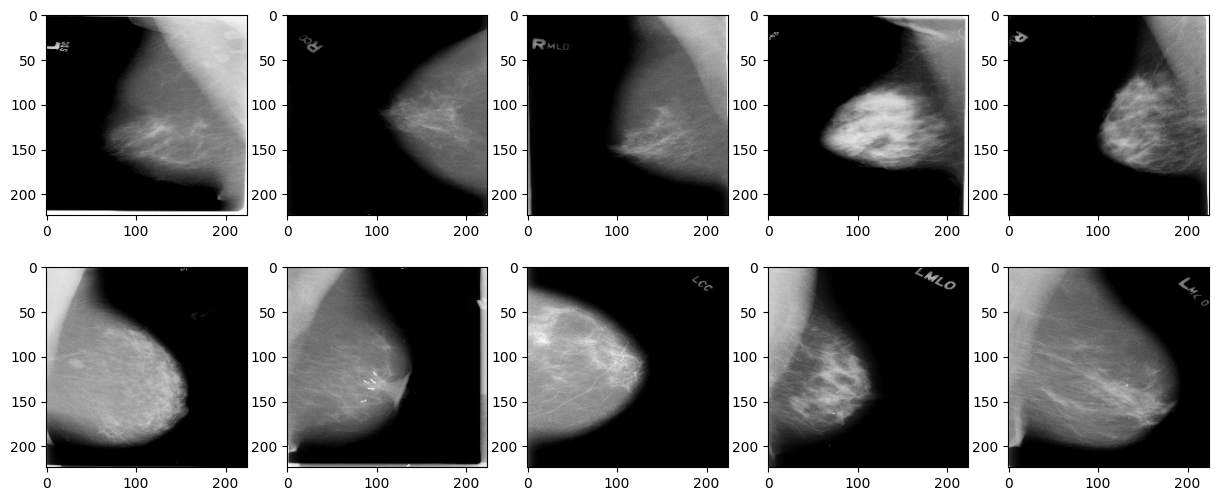

In [7]:
import matplotlib.pyplot as plt
def show_imgs(imgs):
    '''
    Muestra una lista de imágenes en una matriz de 2 filas y 5 columnas utilizando Matplotlib.

    Parametros:
    - imgs: Una lista de matrices numpy representando las imágenes a mostrar.
    
    Esta función crea una figura con subtramas dispuestas en una matriz de 2x5.
    Recorre la lista de imágenes y las muestra en estas subtramas. Si hay menos de
    10 imágenes en la lista, los espacios restantes en la matriz quedan en blanco.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(2):
        for j in range(5):
            if i*5 + j < len(imgs):
                axes[i, j].imshow(imgs[i*5 + j],cmap = 'gray')
                #axes[i, j].axis('off')

    plt.show()
    
show_imgs(imgs)

Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [8]:
unique_labels, unique_counts = np.unique(labels, return_counts=True)

# Crea un diccionario con las etiquetas y sus conteos
labels_histogram = dict(zip(unique_labels, unique_counts))

print(labels_histogram)

{0: 207, 1: 1995, 2: 1406}


In [9]:
labels = np.array(labels)
print(f"Tamaño de imgs: {imgs.shape}")
print(f"Tamaño de labels: {labels.shape}")


Tamaño de imgs: (3608, 224, 224)
Tamaño de labels: (3608,)


In [10]:
print(f"Imágenes con etiqueta 1 (benigno): {np.sum(labels == 1)}")

Imágenes con etiqueta 1 (benigno): 1995


In [21]:
img = imgs[0]

In [12]:
def img_compar(img_original, img_preprocess):
    '''
    Funcion utilizada para comparar la imagen antes y despues del procesmiento
    
    Parametros: 
    - img_original: imagen antes del procesamiento
    - img_preprocess: imagen procesada
    
    Output: La funcion muestra una figura de matplotlib con la imagen original y procesada
    '''
    # Mostrar la imagen original y la imagen preprocesada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

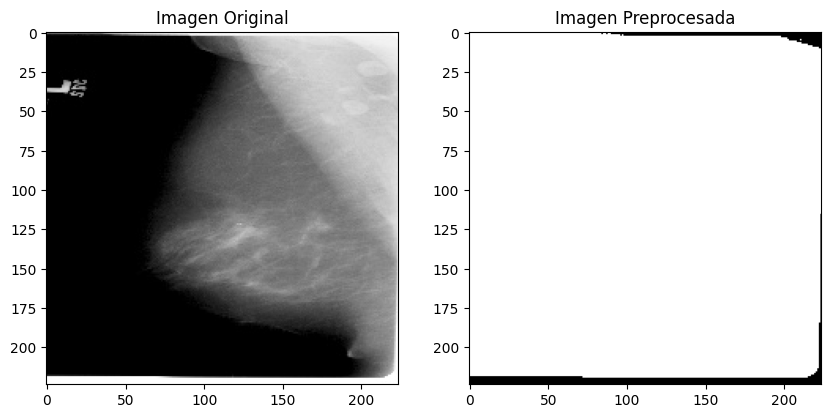

In [22]:
def mask(img):
    mask = cv2.inRange(img, 240, 255)
    mask_inv = cv2.bitwise_not(mask)
    return mask_inv
mask_inv = mask(img)
img_compar(img,mask_inv)

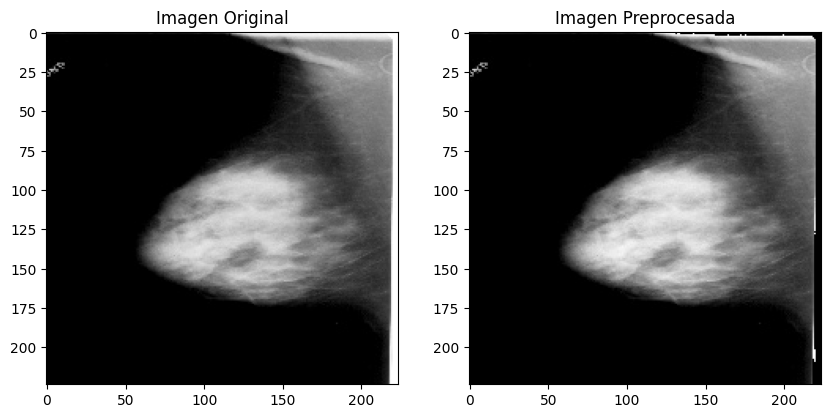

In [19]:

def apply_mask(image, mask):
    # Convertir la máscara a binaria (0 y 1) para hacer la operación de enmascaramiento
    mask_binary = mask // 255  # Asegurar que los valores sean 0 (negro) o 1 (blanco)

    # Aplicar la máscara a la imagen original
    image_masked = image * mask_binary

    return image_masked

# Aplicar la máscara invertida a la imagen original
image_masked = apply_mask(img, mask_inv)

img_compar(img,image_masked)

In [15]:
def keep_size(img,desired_size):
    image_padded_final = cv2.copyMakeBorder(img, 
                                        top=(desired_size[0] - img.shape[0]) // 2,
                                        bottom=(desired_size[0] - img.shape[0] + 1) // 2,
                                        left=(desired_size[1] - img.shape[1]) // 2,
                                        right=(desired_size[1] - img.shape[1] + 1) // 2,
                                        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return image_padded_final

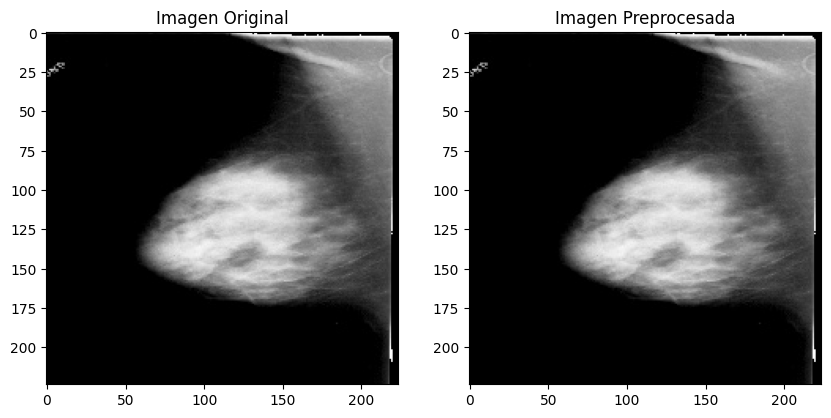

In [20]:
def remove_vertical_white_borders(image):
    # Detectar las columnas cuyo valor promedio sea cercano al blanco (por ejemplo, > 220)
    column_sums = np.mean(image, axis=0)
    non_white_columns = np.where(column_sums < 220)[0]
    
    if len(non_white_columns) > 0:
        # Obtener las columnas no blancas mínimas y máximas
        x_min = non_white_columns[0]
        x_max = non_white_columns[-1]
        
        # Recortar la imagen según las columnas no blancas
        image_cropped = image[:, x_min:x_max]
        image_cropped = keep_size(image_cropped,(224,224))
    else:
        # Si no se detectan columnas no blancas, devolver la imagen original
        image_cropped = image
    
    return image_cropped

# Aplicar la función a la imagen original
image_cropped_vertical = remove_vertical_white_borders(image_masked)
img_compar(image_masked,image_cropped_vertical)

In [129]:
image_padded.shape

(224, 224)

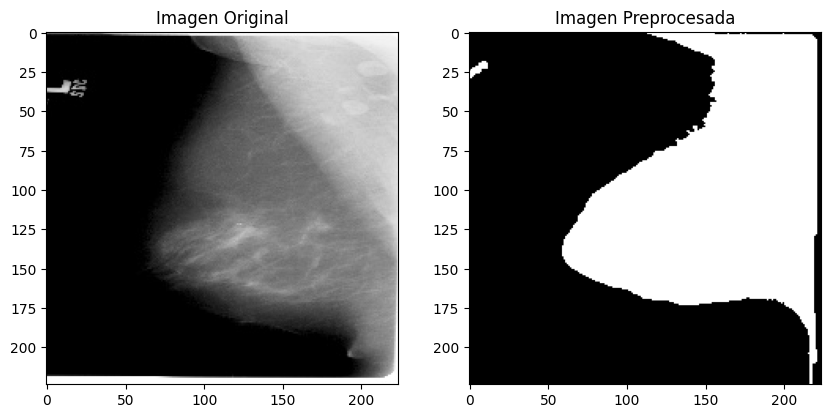

In [24]:
def gaussian_and_tresholdA(img, gaussian_kernel_size=(3,3),adaptive_thresh_blocksize=11, adaptive_thresh_C=2):
    """
    Aplica un filtro gaussiano para suavizar una imagen y luego aplica un umbral binario.

    Parametros:
        img (numpy.ndarray): La imagen de entrada.
        gaussian_kernel_size (tuple, opcional): Tamaño del kernel gaussiano. Por defecto es (5, 5).
        adaptive_thresh_blocksize (int, opcional): Tamaño del bloque para la umbralización adaptativa. Por defecto es 11.
        adaptive_thresh_C (int, opcional): Constante substraída en la umbralización adaptativa. Por defecto es 2.

    Retorno:
        numpy.ndarray: La imagen con umbral binario aplicado.
    """
    
    # Aplicar un filtro gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(img, gaussian_kernel_size, 0)
    
    # Aplicar umbralización adaptativa para resaltar las regiones de interés
    #adaptive_threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              # cv2.THRESH_BINARY_INV, adaptive_thresh_blocksize, adaptive_thresh_C)
    #_, otsu_threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    _,th1 = cv2.threshold(blurred,25,255,cv2.THRESH_BINARY)

    return th1

gaus_thres_img = gaussian_and_tresholdA(image_cropped_vertical)

img_compar(img,gaus_thres_img)
                                               

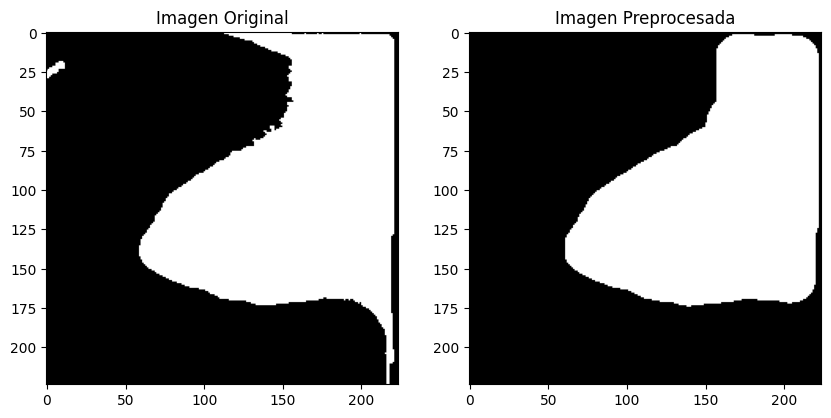

In [25]:
def filter_morph_open(img,morph_kernel_size=(30,30)):
    
    """
    Aplica una operación morfológica para eliminar pequeños artefactos de una imagen.

    Args:
        img (numpy.ndarray): La imagen de entrada.
        morph_kernel_size (tuple, opcional): Tamaño del kernel morfológico. Por defecto es (30, 30).

    Returns:
        numpy.ndarray: La imagen con la operación morfológica aplicada.
    """

    # Aplicar operación morfológica para eliminar pequeños artefactos blancos
    morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, morph_kernel)
    #morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, morph_kernel)

    return morphed

morphed_img = filter_morph_open(gaus_thres_img)

img_compar(gaus_thres_img,morphed_img)

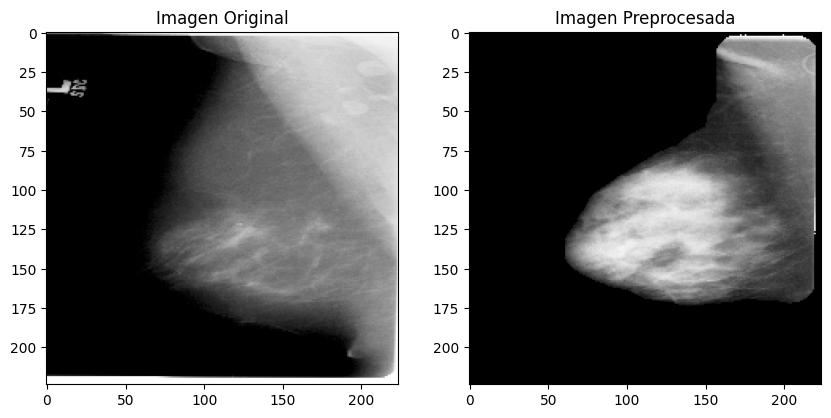

In [27]:
def extract_largest_component(morphed,gaus_thres_img,original):
    
    """
    Encuentra el componente conectado más grande (asumido como el seno) en la imagen morfológicamente procesada 
    y lo extrae de la imagen original.

    Args:
        morphed (numpy.ndarray): Imagen procesada morfológicamente.
        gaus_thres_img (numpy.ndarray): Imagen con filtro haussiano y threshold.
        original (numpy.ndarray): Imagen original.

    Returns:
        numpy.ndarray: Imagen original con solo el componente más grande conservado.
    """
     # Encontrar todos los componentes conectados
    num_labels, labels_im = cv2.connectedComponents(morphed)

    #print("numero de componentes: ",num_labels)
    #print("labels img: ",labels_im)
    
    # Eliminar componentes conectados pequeños (asumimos que el seno es el componente más grande)
    unique, counts = np.unique(labels_im, return_counts=True)

    #print("unique components: ",unique)
    #print("counts : ",counts)
    #print("fondo: " ,counts[0])
    # Ignorar el fondo
    counts[0] = 0
    
    # Encontrar el componente más grande
    max_label = unique[np.argmax(counts)]

    #print("componente mas grande: ",max_label)
    
    # Crear una máscara solo con el componente más grande
    cleaned_background = np.zeros(gaus_thres_img.shape, np.uint8)

    cleaned_background[labels_im == max_label] = 255
    
    # Aplicar la máscara para mantener solo el objeto principal
    cleaned_image = cv2.bitwise_and(original, original, mask=cleaned_background)

    return cleaned_image

nose_img = extract_largest_component(morphed_img,gaus_thres_img,image_cropped_vertical)

img_compar(img,nose_img)



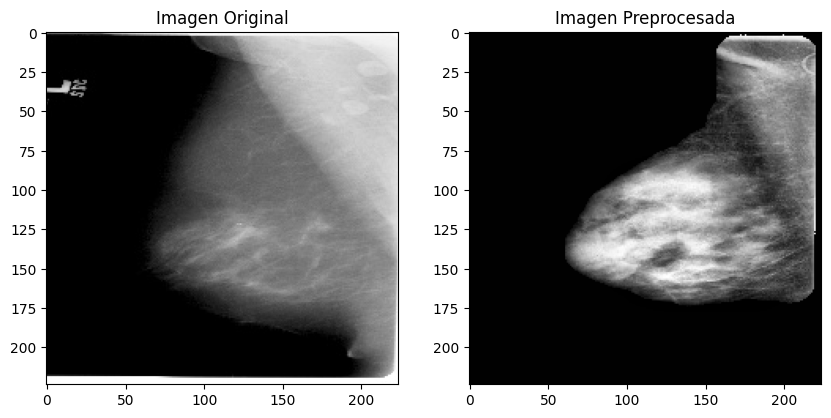

In [28]:
def filter_clahe(img):
    """
    Aplica el filtro de Adaptive Histogram Equalization (CLAHE) a una imagen para mejorar el contraste.

    Parameters:
    img (numpy.ndarray): Imagen en escala de grises a la cual se aplicará el filtro CLAHE. 
                         La imagen debe estar en formato de matriz bidimensional (grayscale).

    Returns:
    numpy.ndarray: Imagen procesada después de aplicar CLAHE, con un mejor contraste.
    """
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    final_image = clahe.apply(img)
    return final_image

clahe_img = filter_clahe(nose_img)
img_compar(img,clahe_img)

In [222]:
def images_processor(imgs):
    imgs_processor = []
    for img in imgs:
        mask_inv = mask(img)
        applied_mask_img = apply_mask(img,mask_inv)
        vertical_cut = remove_vertical_white_borders(applied_mask_img)
        threshold_img = gaussian_and_tresholdA(vertical_cut)
        morphology = filter_morph_open(threshold_img)
        cleaned_img = extract_largest_component(morphology,threshold_img,vertical_cut)
        clahe_img = filter_clahe(cleaned_img)
        normalized_img = (clahe_img / 255.0).astype(np.float32)
        imgs_processor.append(normalized_img)

    return np.array(imgs_processor)




In [223]:
imgs_processor = images_processor(imgs)

In [225]:
imgs_processor[2]

array([[0.01176471, 0.01176471, 0.01176471, ..., 0.7058824 , 0.9490196 ,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.7294118 , 0.9411765 ,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.7607843 , 0.9411765 ,
        0.01176471],
       ...,
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471]], dtype=float32)

In [227]:
benign_images = imgs_processor[labels == 2]
print(len(benign_images))

1406


In [228]:
imgs_processor[0].shape

(224, 224)

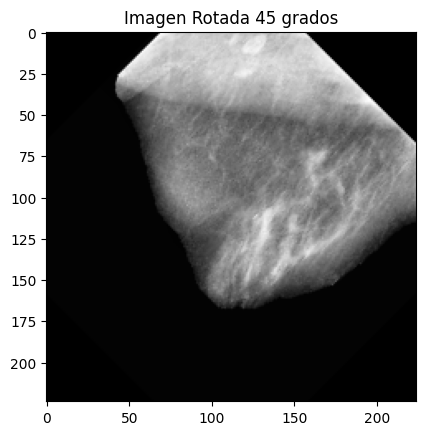

In [251]:
def rotate_image(image, angle):
    # Obtener el tamaño de la imagen original
    h, w = image.shape[:2]

    # Calcular el centro de la imagen
    center = (w // 2, h // 2)

    # Crear la matriz de rotación
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotar la imagen, conservando el tamaño original y usando relleno negro para las áreas vacías
    rotated_image = cv2.warpAffine(image, M, (w, h), borderValue=(0, 0, 0))

    return rotated_image

# Probar la función con una imagen de 224x224
angle = 45  # Rotar 45 grados como ejemplo
rotated_img = rotate_image(imgs_processor[0], angle)

# Mostrar la imagen rotada de tamaño original 224x224
plt.imshow(rotated_img, cmap='gray')
plt.title(f'Imagen Rotada {angle} grados')
plt.show()

In [252]:
rotated_img.shape

(224, 224)

In [257]:
def rotate_image_custom(image):
    angle = 20  # O puedes hacerlo aleatorio para cada imagen
    rotated = rotate_image(image.squeeze(), angle)  # Aplicar la rotación y eliminar cualquier dimensión extra
    return np.expand_dims(rotated, axis=-1)

In [259]:
# Definir el Data Generator con transformaciones
datagen = ImageDataGenerator(
    preprocessing_function=rotate_image_custom,  # Aplicar la rotación personalizada
    rotation_range=0,  # Desactivar rotación del generador por defecto
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='constant',  # Relleno constante
    cval=0  # Rellenar con negro
)

In [274]:
save_dir = 'database/datasetV3/benigno'  # Especifica el directorio donde se guardarán las imágenes
os.makedirs(save_dir, exist_ok=True)

In [275]:
# Filtrar las imágenes benignas (clase 1)
benign_images = imgs_processor[labels == 1]  # Filtrar las imágenes de la clase 2 (benigno)

# Asegurarse de que las imágenes tienen una dimensión de canal correcta (224, 224, 1)
benign_images = np.expand_dims(benign_images, axis=-1)  # Expande la dimensión del canal

for i, img in enumerate(benign_images):
    img_to_save = (img.squeeze() * 255).astype('uint8')  # Escalar la imagen de [0, 1] a [0, 255]
    filename = f"benigno_original_{i}.jpg"  # Nombre de archivo
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, img_to_save) 

In [273]:




# Asegúrate de que tienes imágenes
if benign_images.shape[0] > 0:
    # Seleccionar la primera imagen y expandir la dimensión del batch
    img = benign_images[0]  # Selecciona una imagen de ejemplo
    img = np.expand_dims(img, axis=0)  # Ahora es (1, 224, 224, 1)

    # Crear un generador de augmentación
    aug_iter = datagen.flow(benign_images, batch_size=1, save_to_dir=save_dir, 
                            save_prefix='benigno_aug', save_format='jpg')

    # Generar imágenes augmentadas hasta alcanzar 1995
    images_to_generate = 1995 - benign_images.shape[0]  # 589 imágenes por generar
    generated_images = 0

    while generated_images < images_to_generate:
        # Generar el siguiente lote de imágenes augmentadas
        aug_img_batch = next(aug_iter)
        generated_images += aug_img_batch.shape[0]  # Contar cuántas imágenes se han generado
        
        # Guardar las imágenes augmentadas
        for j in range(aug_img_batch.shape[0]):
            if generated_images >= images_to_generate:
                break  # Si ya se han generado suficientes imágenes, detener el bucle

else:
    print("No se encontraron imágenes con la etiqueta 2.")


In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('models/modelo6_MejorSimple.h5')

In [4]:
model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_478 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_278 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_479 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_279 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_87 (Flatten)        (None, 200704)            0         
                                                                 
 dense_184 (Dense)           (None, 64)              